## Wavefile Read/Write

Open and read a wavefile

In [2]:
import wave
import numpy as np
import matplotlib.pyplot as plt

signal_input_file_path = './electric_guitar_sample.wav'
signal_output_file_path = './outputs/unaltered_output.wav'

class Audio_Signal:
    def __init__(self, input_file_path, output_file_path):
        self.input_file_path = input_file_path
        self.output_file_path = output_file_path

    def load_audio(self):
        audio_signal = wave.open(self.input_file_path, 'r')
        
        self.frame_count = audio_signal.getnframes()
        self.channel_count = audio_signal.getnchannels()
        self.sample_width = audio_signal.getsampwidth()
        self.sample_rate = audio_signal.getframerate()
        self.frame_rate = audio_signal.getframerate() * 2

        self.audio_frames = audio_signal.readframes(self.frame_count)
        self.audio_frames = np.frombuffer(self.audio_frames, dtype = np.int16)
    
    def write_to_wav_file(self):
        output_file = wave.open(self.output_file_path, 'w')
        
        output_file.setnchannels(self.channel_count)
        output_file.setsampwidth(self.sample_width)
        output_file.setframerate(self.sample_rate)
        output_file.writeframes(self.audio_frames)
        
        output_file.close()
    
    def plot_audio_data(self):
        audio_length = len(self.audio_frames)

        self.time_signal = np.linspace(0, audio_length / self.frame_rate, num = audio_length)

        plt.figure()
        plt.plot(self.time_signal, self.audio_frames)
        plt.xlabel("Time (s)")
        plt.ylabel("Signal Amplitude")

        plt.show()
    
    def get_sample_rate(self):
        pass

print("Done")

Done


In [141]:
from scipy.signal import kaiserord, firwin, freqz
from pylab import figure, plot, title, grid, xlabel, ylabel

class Filter:
    def __init__(self, filter_type='empty', nyquist_rate=22050, stop_band_attentuation_dB=10, low_transition_freq=400, high_transition_freq=4000):
        #! Adjust stop_band_attentuation_dB to control signal equalization
        self.filter_type = filter_type
        self.nyquist_rate = nyquist_rate
        self.transition_width = 200 / nyquist_rate #! Assign 5000 value to variable
        self.stop_band_attenuation_dB = stop_band_attentuation_dB
        self.low_transition_freq = low_transition_freq
        self.high_transition_freq = high_transition_freq
        
        self.filter_coefs = []

        self.calculate_filter_order()
        self.generate_filter_coefs()
    
    def calculate_filter_order(self):
        self.FIR_order, self.beta = kaiserord(self.stop_band_attenuation_dB, self.transition_width)
        self.FIR_order *= 3
        if self.FIR_order % 2 == 0:
            self.FIR_order += 1
    
    def generate_filter_coefs(self):
        if self.filter_type == "low":
            self.generate_lowfreq_filter()
        elif self.filter_type == "mid":
            self.generate_midfreq_filter()
        elif self.filter_type == "high":
            self.generate_highfreq_filter()
        elif self.filter_type == 'empty':
            pass
    
    def generate_lowfreq_filter(self):
        self.filter_coefs = firwin(self.FIR_order, self.low_transition_freq, pass_zero='lowpass', fs=self.nyquist_rate*2)

    def generate_midfreq_filter(self):
        self.filter_coefs = firwin(self.FIR_order, [self.low_transition_freq / self.nyquist_rate, self.high_transition_freq / self.nyquist_rate], pass_zero='bandpass')

    def generate_highfreq_filter(self):
        self.filter_coefs = firwin(self.FIR_order, self.high_transition_freq, pass_zero='highpass', fs=self.nyquist_rate*2)

    def write_coefs_to_file(self):
        #! Not sure if this is how to change the filter coefficients in block memory
        pass

    def plot_filter(self):
        figure()
        w, h = freqz(self.filter_coefs, worN=8000)
        plot((w/np.pi)*self.nyquist_rate, np.absolute(h), linewidth=2)
        title('Filter Curves')
        xlabel("Frequency")
        ylabel("Filter Gain")
        grid(True)

print("Done")

Done


In [17]:
input_signal = Audio_Signal(signal_input_file_path, signal_output_file_path)

input_signal.load_audio()

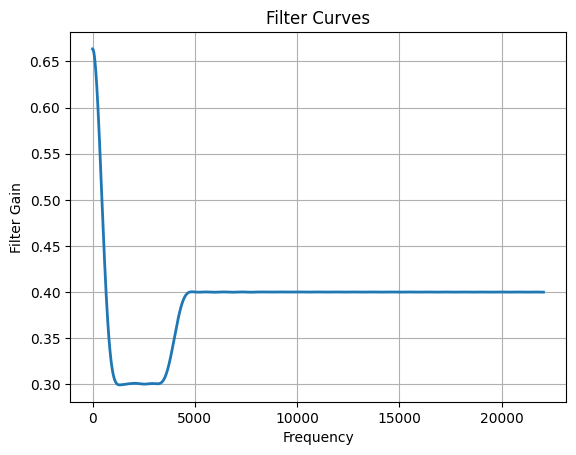

In [144]:
lowfreq_filter = Filter('low')
midfreq_filter = Filter('mid')
highfreq_filter = Filter('high')

# lowfreq_filter.plot_filter()
# midfreq_filter.plot_filter()
# highfreq_filter.plot_filter()

new_filter = Filter()
new_filter.filter_coefs = lowfreq_filter.filter_coefs * 0.6 + midfreq_filter.filter_coefs * 0.3 + highfreq_filter.filter_coefs * 0.4
new_filter.plot_filter()

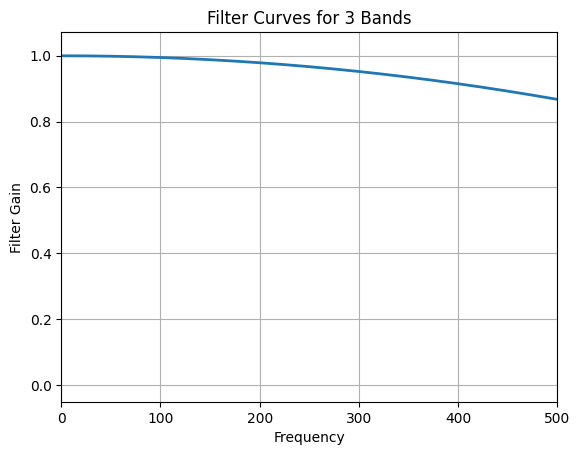

In [11]:
import numpy as np
from scipy.signal import firwin, freqz
import matplotlib.pyplot as plt
from pylab import figure, plot, title, grid, xlabel, ylabel, xlim

# Define the parameters for the bandstop filter
num_taps = 101  # Number of filter taps
cutoff_freq = [2, 8]  # Bandstop filter cutoff frequencies in Hz
sampling_freq = 44100  # Sampling frequency in Hz
nyquist_rate = 22050

# Generate the coefficients for the bandstop filter
coefficients = firwin(num_taps, cutoff_freq, pass_zero=True, fs=sampling_freq)
coefficients = firwin(67, [1000 / 22050, 8000 / 22050], pass_zero='bandstop')

# Plot the frequency response of the filter
# w, h = freqz(coefficients, worN=8000)
# frequencies = (sampling_freq * 0.5 / np.pi) * w
# amplitude_response = 20 * np.log10(abs(h))

# fig, ax1 = plt.subplots()
# ax1.plot(frequencies, amplitude_response, 'b')
# ax1.set_ylabel('Amplitude [dB]', color='b')
# ax1.set_xlabel('Frequency [Hz]')
# ax1.grid()

# plt.title('Frequency response of the bandstop filter')
# plt.show()

figure()
w, h = freqz(coefficients, worN=8000)
plot((w/np.pi)*nyquist_rate, np.absolute(h), linewidth=2)
title('Filter Curves for 3 Bands')
xlabel("Frequency")
ylabel("Filter Gain")
xlim([0, 500])
grid(True)

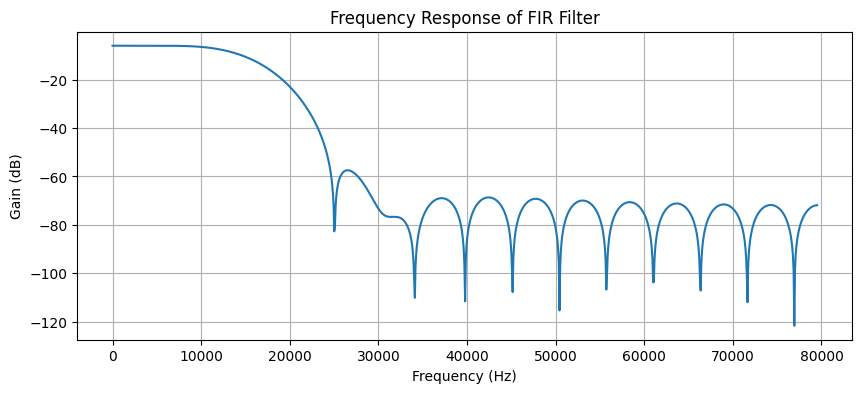

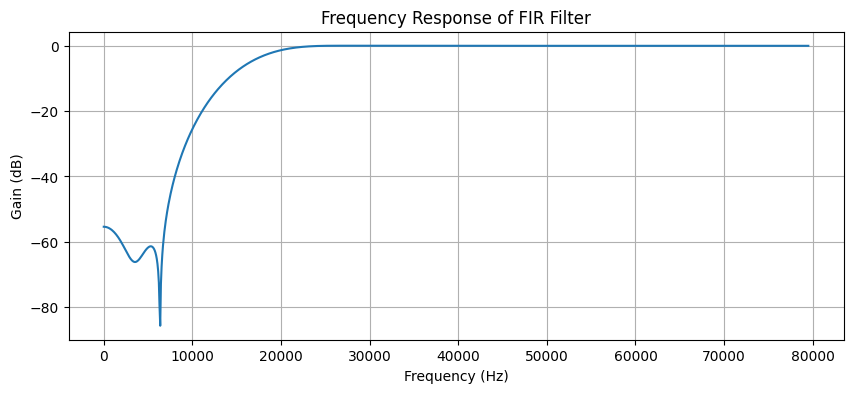

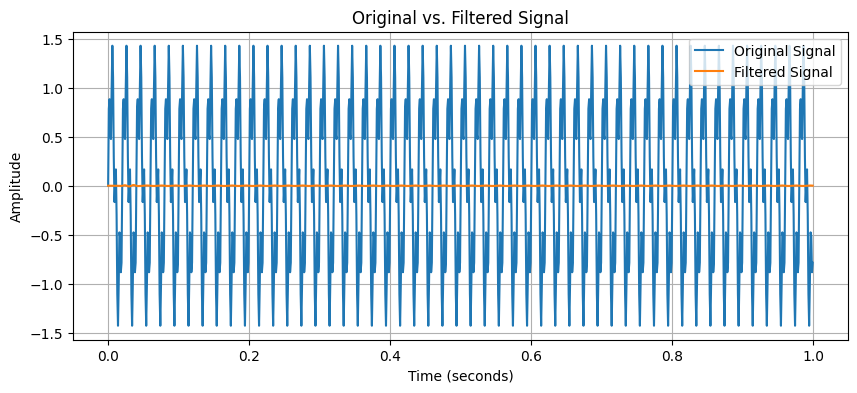

In [83]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter, freqz

# Define filter specifications
Fs = 1000  # Sampling frequency (Hz)
Fc = 100   # Cutoff frequency (Hz)
A = 0.5    # Amplitude reduction factor for high frequencies (50% reduction)

# Calculate normalized cutoff frequency
normalized_fc = Fc / (Fs / 2)

# Design the FIR filter
filter_order = 30  # Adjust filter order based on requirements
b = firwin(filter_order + 1, normalized_fc, pass_zero='lowpass')
c = firwin(filter_order + 1, normalized_fc, pass_zero='highpass')

# Apply amplitude scaling for high frequencies
b_scaled = b * A
c_scaled = c * A

# Plot frequency response of the filter
w, h = freqz(b_scaled, 1, worN=1024, fs=Fs)
plt.figure(figsize=(10, 4))
plt.plot(0.5 * Fs * w / np.pi, 20 * np.log10(np.abs(h)))
plt.title("Frequency Response of FIR Filter")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain (dB)")
plt.grid(True)
plt.show()

w, h = freqz(c, 1, worN=1024, fs=Fs)
plt.figure(figsize=(10, 4))
plt.plot(0.5 * Fs * w / np.pi, 20 * np.log10(np.abs(h)))
plt.title("Frequency Response of FIR Filter")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Gain (dB)")
plt.grid(True)
plt.show()

# Generate a test signal (e.g., sinusoid)
t = np.linspace(0, 1, Fs, endpoint=False)
x = np.sin(2 * np.pi * 50 * t) + 0.5 * np.sin(2 * np.pi * 200 * t)

# Apply the FIR filter to the signal
filtered_signal = lfilter(b_scaled, 1, x)
filtered_signal = lfilter(c_scaled, 1, filtered_signal)

# Plot original and filtered signals
plt.figure(figsize=(10, 4))
plt.plot(t, x, label='Original Signal')
plt.plot(t, filtered_signal, label='Filtered Signal')
plt.title("Original vs. Filtered Signal")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

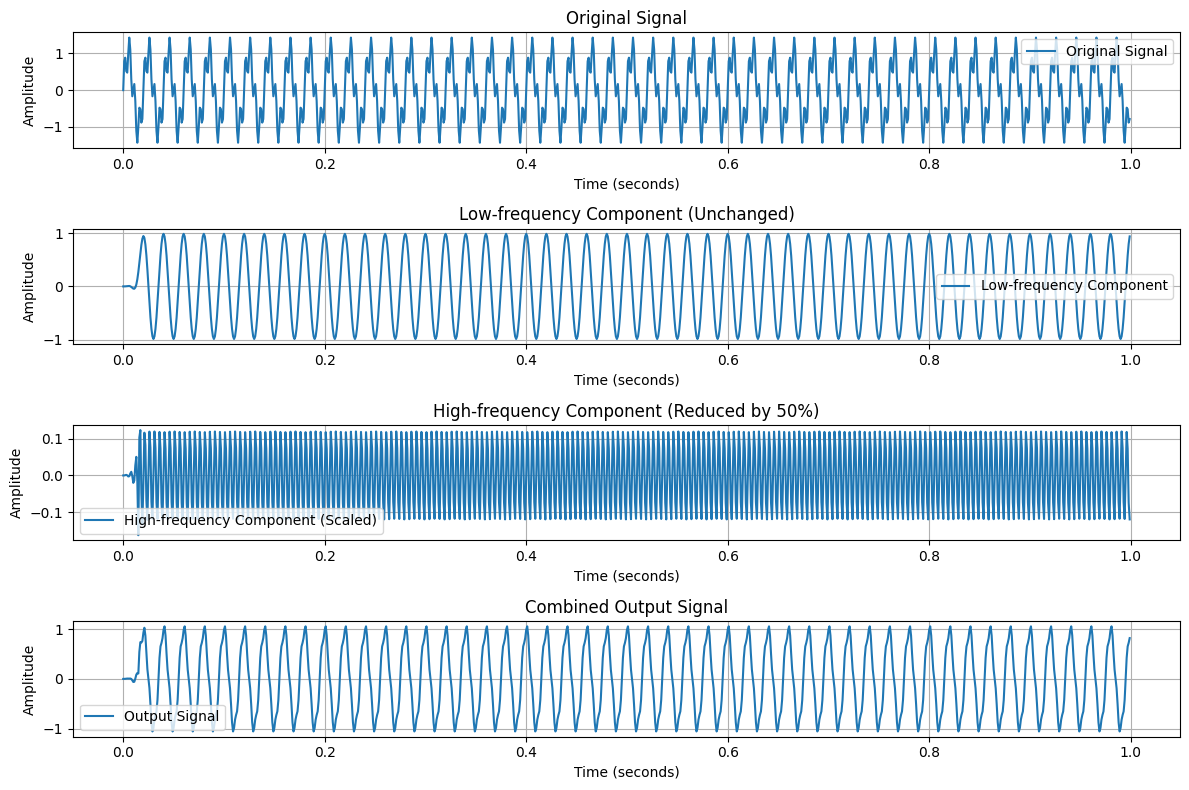

In [63]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import firwin, lfilter

def dual_band_filter(input_signal, Fs, low_cutoff, high_cutoff, high_scale_factor):
    # Calculate normalized cutoff frequencies
    normalized_low_cutoff = low_cutoff / (Fs / 2)
    normalized_high_cutoff = high_cutoff / (Fs / 2)
    
    # Design low-pass FIR filter for low frequencies
    filter_order = 30  # Adjust filter order based on requirements
    low_pass_filter = firwin(filter_order + 1, normalized_low_cutoff, window='hamming')
    
    # Design high-pass FIR filter for high frequencies
    high_pass_filter = -firwin(filter_order + 1, normalized_high_cutoff, window='hamming')
    high_pass_filter[filter_order // 2] += 1.0  # Compensate for delay
    
    # Apply filters to input signal
    low_freq_signal = lfilter(low_pass_filter, 1, input_signal)
    high_freq_signal = lfilter(high_pass_filter, 1, input_signal)
    
    # Scale high frequency component
    high_freq_signal *= high_scale_factor
    
    # Combine low and high frequency components
    output_signal = low_freq_signal + high_freq_signal
    
    return output_signal, low_freq_signal, high_freq_signal

# Define signal and parameters
Fs = 1000  # Sampling frequency (Hz)
t = np.linspace(0, 1, Fs, endpoint=False)
input_signal = np.sin(2 * np.pi * 50 * t) + 0.5 * np.sin(2 * np.pi * 200 * t)

# Define filter cutoff frequencies and scaling factor
low_cutoff = 100  # Low-pass cutoff frequency (Hz)
high_cutoff = 200  # High-pass cutoff frequency (Hz)
high_scale_factor = 0.5  # Scaling factor for high frequencies

# Apply dual-band filtering
output_signal, low_freq_component, high_freq_component = dual_band_filter(input_signal, Fs, low_cutoff, high_cutoff, high_scale_factor)

# Plot original, low-frequency, high-frequency, and output signals
plt.figure(figsize=(12, 8))

# Plot original input signal
plt.subplot(4, 1, 1)
plt.plot(t, input_signal, label='Original Signal')
plt.title('Original Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

# Plot low-frequency component
plt.subplot(4, 1, 2)
plt.plot(t, low_freq_component, label='Low-frequency Component')
plt.title('Low-frequency Component (Unchanged)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

# Plot high-frequency component
plt.subplot(4, 1, 3)
plt.plot(t, high_freq_component, label='High-frequency Component (Scaled)')
plt.title('High-frequency Component (Reduced by 50%)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

# Plot output signal
plt.subplot(4, 1, 4)
plt.plot(t, output_signal, label='Output Signal')
plt.title('Combined Output Signal')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()